In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [5]:
sys.path.append('../../') 

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot

### get the individual EEZs

In [7]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [8]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

<AxesSubplot:>

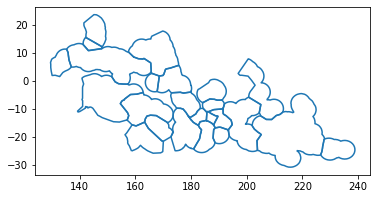

In [9]:
EEZs.boundary.plot()

### year and month (initial month of the forecast)

In [10]:
year = 2021

In [12]:
month = 7

### number of days for the GPM-IMERG accumulation 

In [13]:
ndays = 90 

### list the files GPM-IMERG first 

In [14]:
def sort_key(f): 
    from datetime import datetime
    return datetime.strptime(f.name.split('_')[-1].split('.')[0], '%Y-%m-%d') 

In [15]:
dpath_GPM = HOME.joinpath('operational/ICU/development/hotspots/outputs/GPM_IMERG')

In [16]:
lfiles = list(dpath_GPM.glob(f"GPM_IMERG_accum_{ndays}ndays_to_*.nc"))

In [20]:
lfiles.sort(key=sort_key)

In [22]:
lfiles[-10:]

[PosixPath('/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG/GPM_IMERG_accum_90ndays_to_2021-05-24.nc'),
 PosixPath('/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG/GPM_IMERG_accum_90ndays_to_2021-05-25.nc'),
 PosixPath('/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG/GPM_IMERG_accum_90ndays_to_2021-05-29.nc'),
 PosixPath('/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG/GPM_IMERG_accum_90ndays_to_2021-05-31.nc'),
 PosixPath('/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG/GPM_IMERG_accum_90ndays_to_2021-06-13.nc'),
 PosixPath('/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG/GPM_IMERG_accum_90ndays_to_2021-06-15.nc'),
 PosixPath('/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG/GPM_IMERG_accum_90ndays_to_2021-07-04.nc'),
 PosixPath('/home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG/GPM_IMERG_accum_90ndays_to_2021-07-1

### we assume we want the last day of the month preceding the nominal forecast start 

In [23]:
if datetime(year, month, 1) - timedelta(days=1) in [sort_key(f) for f in lfiles]: 
    
    ifile = [sort_key(f) for f in lfiles].index(datetime(year, month, 1) - timedelta(days=1)) 
    
    dset_gpm = xr.open_dataset(lfiles[-1])

else: 
    
    print(f"GPM file for date {datetime(year, month, 1) - timedelta(days=1):%Y-%m-%d} not in {str(dpath_GPM)}")

GPM file for date 2021-06-30 not in /home/nicolasf/operational/ICU/development/hotspots/outputs/GPM_IMERG


In [25]:
dset_gpm = xr.open_dataset(lfiles[-1])

In [26]:
dset_gpm

<xarray.Dataset>
Dimensions:           (lat: 220, lon: 439, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2021-07-26
  * lat               (lat) float64 -30.88 -30.62 -30.38 ... 23.38 23.62 23.88
  * lon               (lon) float64 129.4 129.6 129.9 ... 238.4 238.6 238.9
Data variables:
    precipitationCal  (time, lat, lon) float64 ...
    pctscore          (time, lat, lon) float64 ...
    anoms             (time, lat, lon) float64 ...
    EEZ               (lat, lon) float64 ...
Attributes:
    BeginDate:       2021-04-28
    BeginTime:       00:00:00.000Z
    EndDate:         2021-04-28
    EndTime:         23:59:59.999Z
    FileHeader:      StartGranuleDateTime=2021-04-28T00:00:00.000Z;\nStopGran...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20210428-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2021-04-29T14:43:29.104Z
    ndays:           90
    last_day:        2021-07-26

### read the probabilistic forecasts from the GCMs now 

In [27]:
period = 'monthly'

In [28]:
if period == 'seasonal': 
    offset = 3
elif period == 'monthly': 
    offset = 1

In [29]:
quantile = 'percentile'

In [30]:
varname = 'precip'

In [31]:
dpath = CWD.parents[1].joinpath("outputs/C3S")

### list the files 

In [32]:
lfiles = list(dpath.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

In [33]:
[f.name for f in lfiles]

['monthly_percentiles_probabilities_from_2021-07_ECMWF.netcdf',
 'monthly_percentiles_probabilities_from_2021-07_METEO_FRANCE.netcdf',
 'monthly_percentiles_probabilities_from_2021-07_NCEP.netcdf',
 'monthly_percentiles_probabilities_from_2021-07_CMCC.netcdf',
 'monthly_percentiles_probabilities_from_2021-07_ECCC.netcdf',
 'monthly_percentiles_probabilities_from_2021-07_JMA.netcdf',
 'monthly_percentiles_probabilities_from_2021-07_UKMO.netcdf',
 'monthly_percentiles_probabilities_from_2021-07_DWD.netcdf']

In [34]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', engine='netcdf4') 

In [35]:
probs

,Array,Chunk
Bytes,62.81 MiB,7.85 MiB
Shape,"(8, 21, 1, 5, 81, 121)","(1, 21, 1, 5, 81, 121)"
Count,24 Tasks,8 Chunks
Type,float64,numpy.ndarray


### calculates the average across the GCM dimension 

In [36]:
probs_mean = probs.mean('GCM')

### because of all the numerical approximations, it can happen that the sum (over the `GCM` dimension) ends up slightly over 100 (the errors accumulate over all the dimensions)

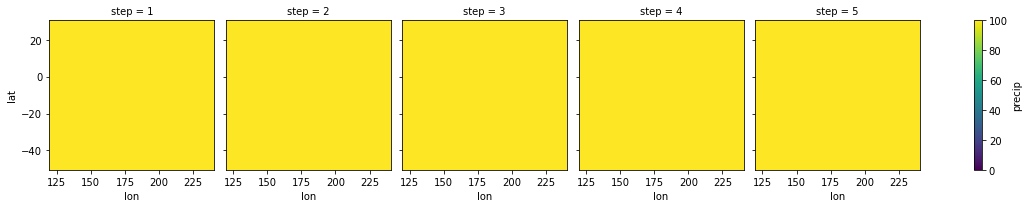

In [37]:
_ = probs_mean.sum(quantile).squeeze()[varname].plot(col='step', vmin=0)

### so we rescale, just in case, if there were not values over 100, it does not change anything 

In [38]:
probs_mean = (probs_mean / probs_mean.sum(quantile)) * 100

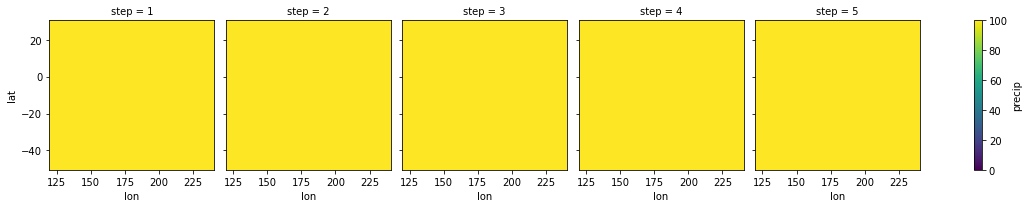

In [39]:
_ = probs_mean.sum(quantile).squeeze()['precip'].plot(col='step', vmin=0)

In [40]:
probs_mean.attrs = probs.attrs

### probability for being below a given percentile

#### choose the percentile here 

In [41]:
pmax = 25

In [42]:
percentile_bins = probs_mean.attrs['pct_values']

max_cat = np.digitize(pmax / 100, percentile_bins)

In [43]:
max_cat

6

### Probability of the most likely quantile 

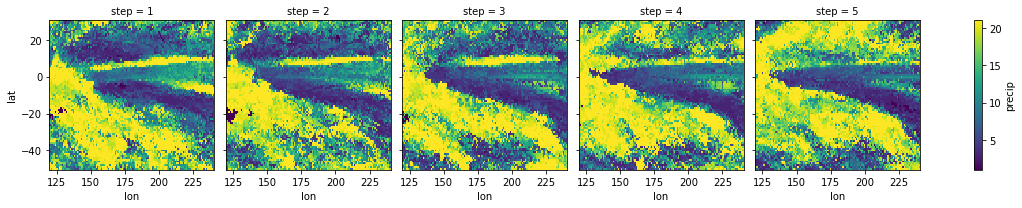

In [44]:
probs_mean.idxmax(dim='percentile')['precip'].squeeze().plot(col='step')

In [45]:
prob_of_most_likely_quantile = probs_mean.max(dim='percentile')

### cumulative probability over the percentile dimension 

In [46]:
cumulative_probs = probs_mean.cumsum(dim='percentile')

In [47]:
cumulative_probs = cumulative_probs.sel(percentile=max_cat)

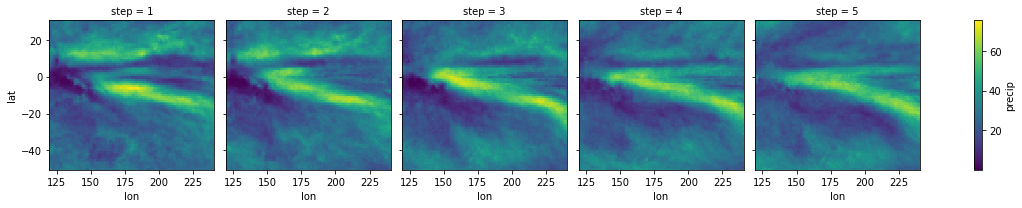

In [48]:
_ = cumulative_probs['precip'].plot(col='step')

### minimum probabilty for rainfall being below `pmax` 

In [49]:
min_prob = 50

In [50]:
cumulative_probs = cumulative_probs.where(cumulative_probs >= min_prob)

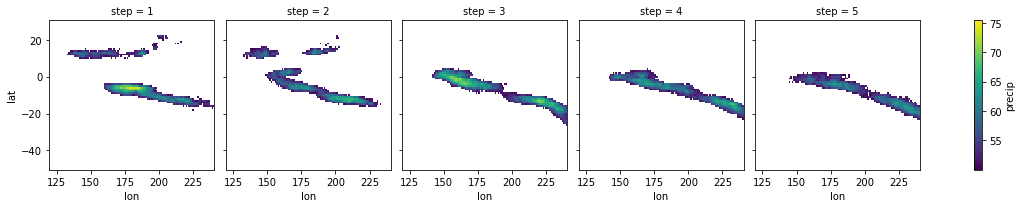

In [51]:
_ = cumulative_probs['precip'].squeeze().plot(col='step')

### can now set a mask 

In [52]:
forecast_mask = cumulative_probs.where(np.isnan(cumulative_probs['precip']), other=1)

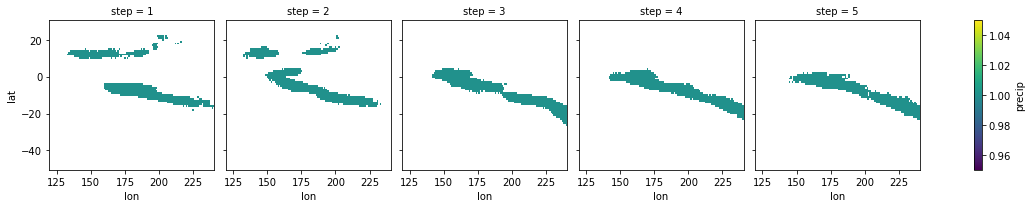

In [53]:
forecast_mask['precip'].plot(col='step')

### Now subsets, then interpolate on the GPM-IMERG grid 

In [54]:
forecast_mask = forecast_mask.sel(lon=slice(dset_gpm['lon'].min(), dset_gpm['lon'].max()), lat=slice(dset_gpm['lat'].min(), dset_gpm['lat'].max()))

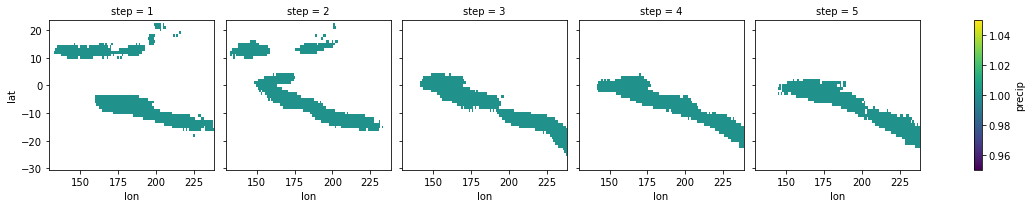

In [55]:
forecast_mask['precip'].plot(col='step')

In [56]:
forecast_mask = forecast_mask.interp_like(dset_gpm[['lat','lon']], method='nearest')

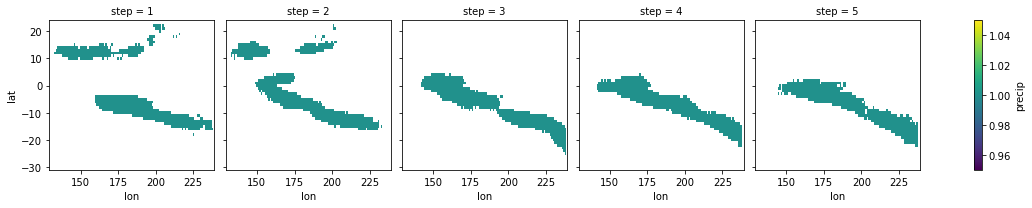

In [57]:
forecast_mask['precip'].plot(col='step')

### consolidated dataset with the GPM imerg percentile of score, for conditional statements 

In [58]:
consolidated_dset = forecast_mask.copy()

In [59]:
consolidated_dset = consolidated_dset.merge(dset_gpm[['pctscore','EEZ']].squeeze().drop('time'))

In [60]:
consolidated_dset

<xarray.Dataset>
Dimensions:   (lat: 220, lon: 439, step: 5, time: 1)
Coordinates:
  * time      (time) datetime64[ns] 2021-07-01
  * step      (step) int64 1 2 3 4 5
    month     int64 7
  * lat       (lat) float64 -30.88 -30.62 -30.38 -30.12 ... 23.38 23.62 23.88
  * lon       (lon) float64 129.4 129.6 129.9 130.1 ... 238.1 238.4 238.6 238.9
Data variables:
    precip    (time, step, lat, lon) float64 dask.array<chunksize=(1, 5, 220, 439), meta=np.ndarray>
    pctscore  (lat, lon) float64 85.0 82.0 75.0 74.0 ... 22.0 22.0 17.0 18.0
    EEZ       (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

### first category: areas moving to water stress conditions  

#### 1st condition: the past 90 days accumulation needs to be between the 25th AND 40th percentile 

In [61]:
hotspot_1 = consolidated_dset[['precip']].where(consolidated_dset['pctscore'] <= 40).where(consolidated_dset['pctscore'] > 25).squeeze()

#### 2nd condition, all the future months (1 to 3) need to be below or equal to category 6 (25th percentile)

In [62]:
hotspot_1 = hotspot_1.where(hotspot_1.isel(step=0) == 1)

#### the result gets assigned category 1

In [63]:
hotspot_1 = hotspot_1.where(np.isnan(hotspot_1), other=1)

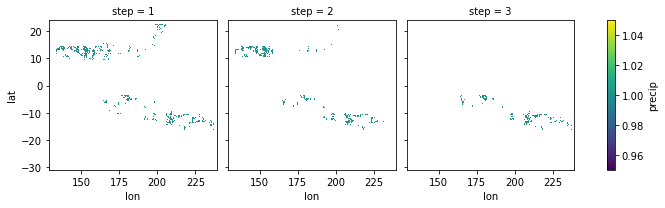

In [64]:
hotspot_1['precip'].sel(step=slice(1,3)).plot(col='step')

### second category: current water stress conditions, persisting or getting worse 

#### 1st condition, the past 90 days accumulation needs to be below or equal to the 25th percentile 

In [65]:
hotspot_2 = consolidated_dset[['precip']].where(consolidated_dset['pctscore'] <= 25).squeeze()

#### 2nd condition, all the future months (1 to 3) need to be below or equal to category 6 (25th percentile)

In [66]:
# hotspot_2 = ((hotspot_2.where(hotspot_2.sel(step=1) <= max_cat)).where(hotspot_2.sel(step=2) <= max_cat)).where(hotspot_2.sel(step=3) <= max_cat) 

In [67]:
hotspot_2 = hotspot_2.where(hotspot_2.sel(step=1) ==  1)

#### 3rd condition, optional, the categories need to either remain stable, or decrease (becoming drier)

In [68]:
# hotspot_2 = hotspot_2.where(hotspot_2.sel(step=1) >= hotspot_2.sel(step=2)).where(hotspot_2.sel(step=2) >= hotspot_2.sel(step=3))

#### the result gets assigned category 2

In [69]:
hotspot_2 = hotspot_2.where(np.isnan(hotspot_2), other=2)

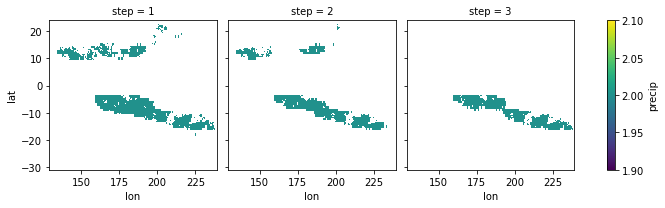

In [70]:
hotspot_2['precip'].sel(step=slice(1,3)).plot(col='step')

### third category: current water stress conditions potentially easing 

#### 1st condition: the past 90 days accumulation needs to be below or equal to the 25th percentile 

In [71]:
hotspot_3 = consolidated_dset[['precip']].where(consolidated_dset['pctscore'] <= 25).squeeze()

#### 2nd condition: the future 3 months need to be strictly above category 6 (25th percentile)

In [72]:
# hotspot_3 = ((hotspot_3.where(hotspot_3.sel(step=1) > max_cat)).where(hotspot_3.sel(step=2) > max_cat)).where(hotspot_3.sel(step=3) > max_cat)

In [73]:
hotspot_3 = hotspot_3.where(hotspot_3.sel(step=1) > max_cat)

In [74]:
# hotspot_3 = hotspot_3.where(hotspot_3.sel(step=slice(1, 3)) > max_cat)

#### 3rd condition, optional the future 3 months categories need to remain stable or increase

In [75]:
# hotspot_3 = hotspot_3.where(hotspot_3.sel(step=1) <= hotspot_3.sel(step=2)).where(hotspot_3.sel(step=2) <= hotspot_3.sel(step=3))

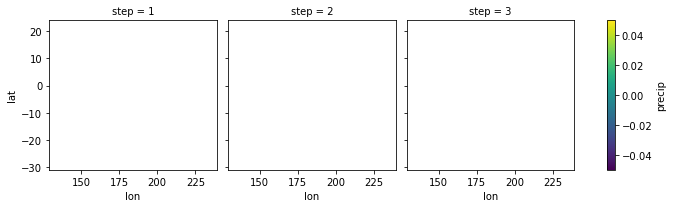

In [76]:
hotspot_3['precip'].sel(step=slice(1,3)).plot(col='step')

#### the result gets assigned category 2

In [77]:
hotspot_3 = hotspot_3.where(np.isnan(hotspot_3), other=3)

### concatenate along a dummy dimension, calculate the max along this dimension, and optionally selects the domain 

In [78]:
hotspot = xr.concat([hotspot_1, hotspot_2, hotspot_3], dim='category')

In [79]:
hotspot = hotspot.max(dim='category')

In [80]:
domain = [140, 240, -38, 20]

In [81]:
hotspot = hotspot.sel(lat=slice(*domain[2:]), lon=slice(*domain[:2]))

### adds the mask 

In [82]:
hotspot['mask'] = consolidated_dset['EEZ']

### Now plots 

In [83]:
cbar_kwargs = {}
cbar_kwargs['ticks'] = np.arange(1.5, 4+0.5, 1)
cbar_kwargs['shrink'] = 0.5
cbar_kwargs['orientation'] = 'vertical'
cbar_kwargs['aspect'] = 10

In [84]:
cbar_ticklabels = ['Areas moving in to water stress conditions', 'Current water stress conditions persisting',  'Current water stress conditions potentially easing']

In [85]:
rgbs = ['#ffcc00', '#ff0000', '#ccff99']

In [86]:
cmap = matplotlib.colors.ListedColormap(rgbs)

/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/nicolasf/mambaforge/envs/climetlab/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


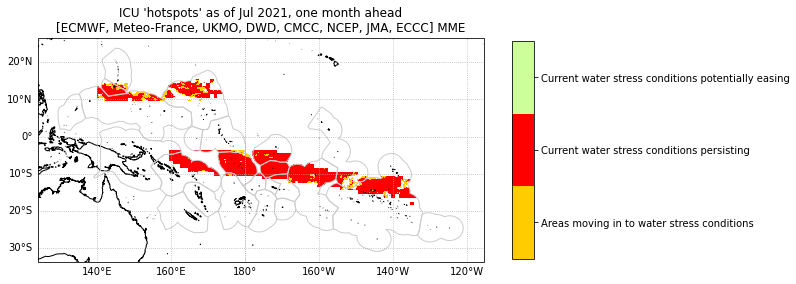

In [87]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(10, 8))

im = (hotspot['precip'] * hotspot['mask']).sel(step=1).plot(ax=ax,
                transform=ccrs.PlateCarree(), \
                levels=[1,2,3,4], add_colorbar=False, cmap=cmap)

EEZs.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='0.8', lw=1)

ax.coastlines(resolution='10m')

cb = plt.colorbar(im, **cbar_kwargs)

cb.ax.set_yticklabels(cbar_ticklabels)

plot.make_gridlines(ax, lon_step=20, lat_step=10)

ax.set_title(f"ICU 'hotspots' as of {month_abbr[month]} {year}, one month ahead\n[ECMWF, Meteo-France, UKMO, DWD, CMCC, NCEP, JMA, ECCC] MME")

# ax.set_extent(domain)

f.savefig(f'./hotspots_prototype_{month}_{year}_monthly_forecast.png', dpi=200, bbox_inches='tight', facecolor='w')